In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import statsmodels.formula.api as smf
import pymc as pm
import bambi as bmb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nfl
import attila_utils

In [2]:
treatments_CO28152 = {
    'A': 'Amiloride',
    'B': 'HCQ',
    'C': 'HCQ nano',
    'D': 'Saline',
    'E': 'R-HCQ',
    'F': 'S-HCQ',
    'G': 'TUDCA',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}
fpath = '../../resources/QPS/5xFAD-mouse/CO28152_NFL-GFAP_datasum.xlsx'
sheet_name = 'NFL in vivo clean'
study = 'CO28152'
fpath_subjects = '../../resources/QPS/5xFAD-mouse/CO28152-animal-list.csv'
dataw_CO28152 = nfl.read_nfl_data(fpath, sheet_name, treatments_CO28152, study, fpath_subjects)
categories = ['Saline', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA', 'Saline WT', 'TUDCA WT', 'DMSO WT']
dataw_CO28152['Treatment'] = pd.Categorical(dataw_CO28152.Treatment, categories=categories, ordered=True)
dataw_CO28152

,Cohort,Group,Sex,Genotype,NF-L week 0,NF-L week 4,NF-L week 8,NF-L week 12,Treatment,Study,ΔNfl week 0,ΔNfl week 4,ΔNfl week 8,ΔNfl week 12,max_ΔNfl,Curriculum vitae,Lifespan (weeks)
IRN,,,,,,,,,,,,,,,,,
15117,I,A,f,tg/wt,576.0,861.0,757.0,687.0,Amiloride,CO28152,0.0,285.0,181.0,111.0,285.0,tissue sampling,46.571429
15119,I,A,f,tg/wt,698.0,1042.0,783.0,644.0,Amiloride,CO28152,0.0,344.0,85.0,-54.0,344.0,tissue sampling,46.000000
14627 A,I,A,f,tg/wt,701.0,1085.0,677.0,763.0,Amiloride,CO28152,0.0,384.0,-24.0,62.0,384.0,tissue sampling,46.428571
15161,III,A,f,tg/wt,574.0,710.0,688.0,1028.0,Amiloride,CO28152,0.0,136.0,114.0,454.0,454.0,tissue sampling,47.142857
15938,II,A,m,tg/wt,291.0,559.0,377.0,438.0,Amiloride,CO28152,0.0,268.0,86.0,147.0,268.0,tissue sampling,46.000000
16122,IV,A,m,tg/wt,535.0,609.0,532.0,545.0,Amiloride,CO28152,0.0,74.0,-3.0,10.0,74.0,tissue sampling,46.571429
15127,I,B,f,tg/wt,621.0,739.0,664.0,733.0,HCQ,CO28152,0.0,118.0,43.0,112.0,118.0,tissue sampling,46.000000
15201,IV,B,f,tg/wt,370.0,375.0,638.0,550.0,HCQ,CO28152,0.0,5.0,268.0,180.0,268.0,tissue sampling,46.285714
15245,V,B,f,tg/wt,678.0,593.0,688.0,577.0,HCQ,CO28152,0.0,-85.0,10.0,-101.0,10.0,tissue sampling,46.714286


In [3]:
treatments_CO28154 = {
    'A': 'Saline',
    'B': 'Amiloride + HCQ',
    'C': 'TUDCA + HCQ',
    'D': 'Arundine low dose',
    'E': 'Arundine mid dose',
    'F': 'Arundine high dose',
    'G': 'Vehicle (Arundine)',
    'H': 'Arundine high dose WT',
    'I': 'Amiloride + HCQ WT',
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}
fpath = '../../resources/QPS/5xFAD-mouse/CO28154-biochemistry-cleaned.xlsx'
sheet_name = 'NF-L invivo'
study = 'CO28154'
fpath_subjects = '../../resources/QPS/5xFAD-mouse/CO28154-animal-list.csv'
dataw_CO28154 = nfl.read_nfl_data(fpath, sheet_name, treatments_CO28154, study, fpath_subjects)
categories = ['Saline', 'TUDCA + HCQ', 'Vehicle (Arundine)', 'Arundine low dose', 'Arundine mid dose', 'Arundine high dose', 'Saline WT', 'TUDCA + HCQ WT', 'Vehicle (Arundine) WT', 'Arundine high dose WT']
dataw_CO28154['Treatment'] = pd.Categorical(dataw_CO28154.Treatment, categories=categories, ordered=True)
dataw_CO28154

,Cohort,Group,Sex,Genotype,NF-L week 0,NF-L week 4,NF-L week 8,NF-L week 12,Treatment,Study,ΔNfl week 0,ΔNfl week 4,ΔNfl week 8,ΔNfl week 12,max_ΔNfl,Curriculum vitae,Lifespan (weeks)
IRN,,,,,,,,,,,,,,,,,
15721,II,A,f,tg/wt,585.924,473.700,937.089,735.543,Saline,CO28154,0.0,-112.224,351.165,149.619,351.165,Tissue sampling,45.857143
15891,V,A,f,tg/wt,737.520,899.001,971.289,725.907,Saline,CO28154,0.0,161.481,233.769,-11.613,233.769,Tissue sampling,47.142857
16179,VIII,A,f,tg/wt,598.353,782.016,1032.867,789.648,Saline,CO28154,0.0,183.663,434.514,191.295,434.514,Tissue sampling,46.714286
16524,I,A,m,tg/wt,731.694,543.927,639.027,539.493,Saline,CO28154,0.0,-187.767,-92.667,-192.201,-92.667,Tissue sampling,47.000000
16542,I,A,m,tg/wt,518.877,627.984,587.706,570.840,Saline,CO28154,0.0,109.107,68.829,51.963,109.107,Tissue sampling,46.714286
16718,II,A,m,tg/wt,777.741,594.213,504.165,575.340,Saline,CO28154,0.0,-183.528,-273.576,-202.401,-183.528,Tissue sampling,44.428571
16532,I,C,m,tg/wt,449.253,458.796,448.677,533.253,TUDCA + HCQ,CO28154,0.0,9.543,-0.576,84.000,84.000,Tissue sampling,46.571429
16540,I,C,m,tg/wt,569.031,758.778,447.492,598.212,TUDCA + HCQ,CO28154,0.0,189.747,-121.539,29.181,189.747,Tissue sampling,46.571429
16688,II,C,m,tg/wt,425.592,528.660,468.531,374.409,TUDCA + HCQ,CO28154,0.0,103.068,42.939,-51.183,103.068,Tissue sampling,45.142857


In [4]:
dataw_CO28152['Curriculum vitae'].unique()

array(['tissue sampling'], dtype=object)

In [5]:
dataw_CO28154['Curriculum vitae'].unique()

array(['Tissue sampling'], dtype=object)

['named-figure/scatter-vs-max_ΔNfl-lifespan_CO28152.png',
 'named-figure/scatter-vs-max_ΔNfl-lifespan_CO28152.pdf']

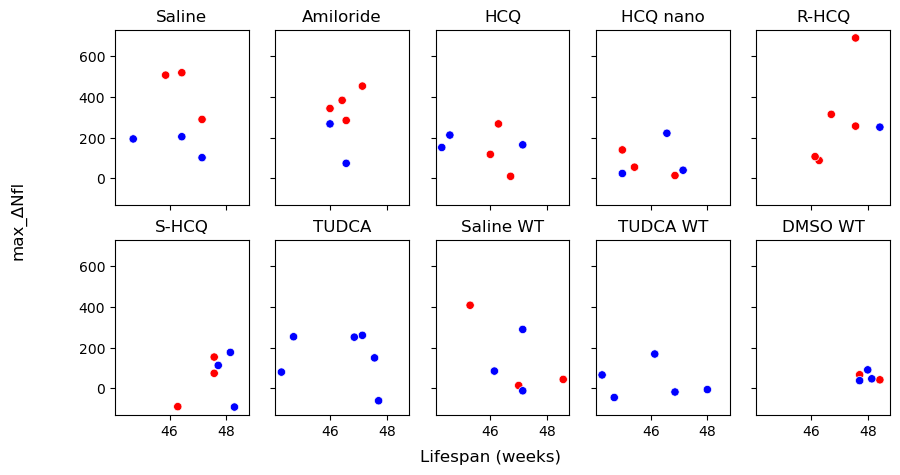

In [6]:
def my_scatter(x='Lifespan (weeks)', dataw=dataw_CO28152):
    fig, ax = plt.subplots(2, 5, figsize=(10, 5), sharey=True, sharex=True)
    for t, axi in zip(dataw.Treatment.cat.categories, ax.ravel()):
        sns.scatterplot(data=dataw.loc[dataw.Treatment == t], y='max_ΔNfl', x=x, ax=axi, hue='Sex', palette=['blue', 'red'], legend=False)
        axi.set_title(t)
        axi.set_xlabel('')
        axi.set_ylabel('')
    
    fig.supxlabel(x)
    fig.supylabel('max_ΔNfl')
    return((fig, ax))

fig, ax = my_scatter('Lifespan (weeks)', dataw_CO28152)
attila_utils.savefig(fig, 'scatter-vs-max_ΔNfl-lifespan_CO28152')

['named-figure/scatter-vs-max_ΔNfl-lifespan_CO28154.png',
 'named-figure/scatter-vs-max_ΔNfl-lifespan_CO28154.pdf']

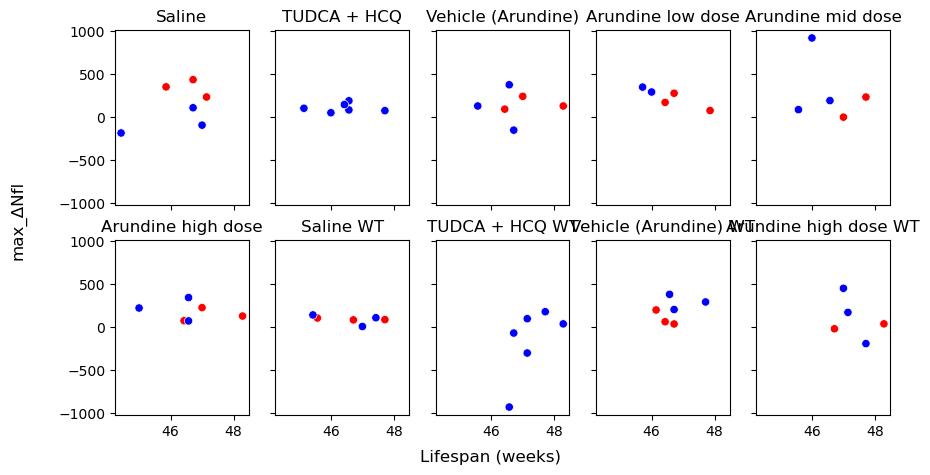

In [7]:
fig, ax = my_scatter('Lifespan (weeks)', dataw_CO28154)
attila_utils.savefig(fig, 'scatter-vs-max_ΔNfl-lifespan_CO28154')

['named-figure/scatter-max_ΔNfl-vs-Nfl-week-0_CO28152.png',
 'named-figure/scatter-max_ΔNfl-vs-Nfl-week-0_CO28152.pdf']

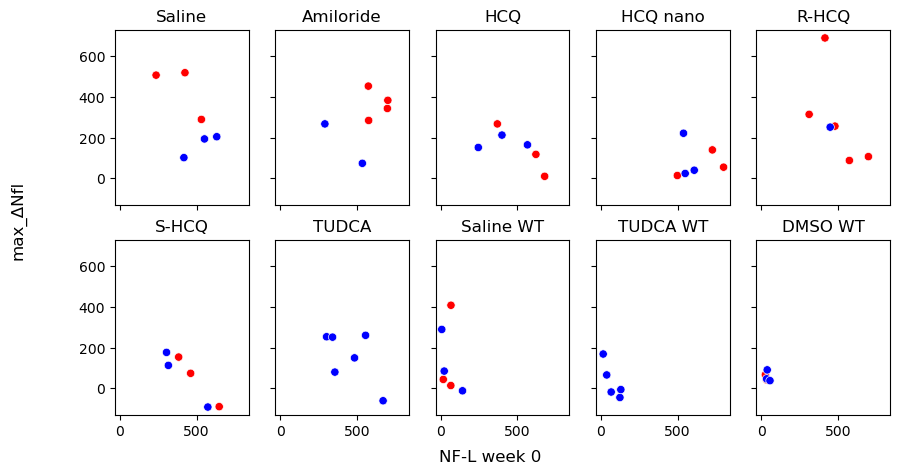

In [8]:
fig, ax = my_scatter('NF-L week 0', dataw_CO28152)
attila_utils.savefig(fig, 'scatter-max_ΔNfl-vs-Nfl-week-0_CO28152')

['named-figure/scatter-max_ΔNfl-vs-Nfl-week-0_CO28154.png',
 'named-figure/scatter-max_ΔNfl-vs-Nfl-week-0_CO28154.pdf']

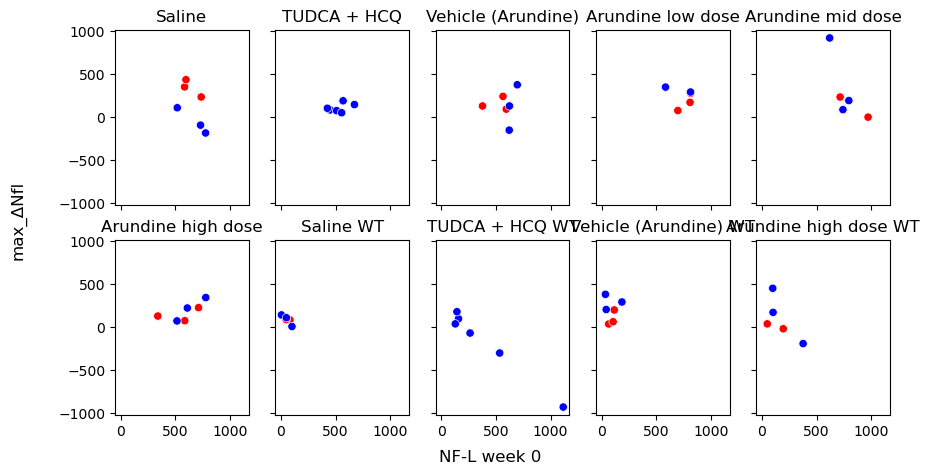

In [9]:
fig, ax = my_scatter('NF-L week 0', dataw_CO28154)
attila_utils.savefig(fig, 'scatter-max_ΔNfl-vs-Nfl-week-0_CO28154')

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


['named-figure/data-violinplot.png', 'named-figure/data-violinplot.pdf']

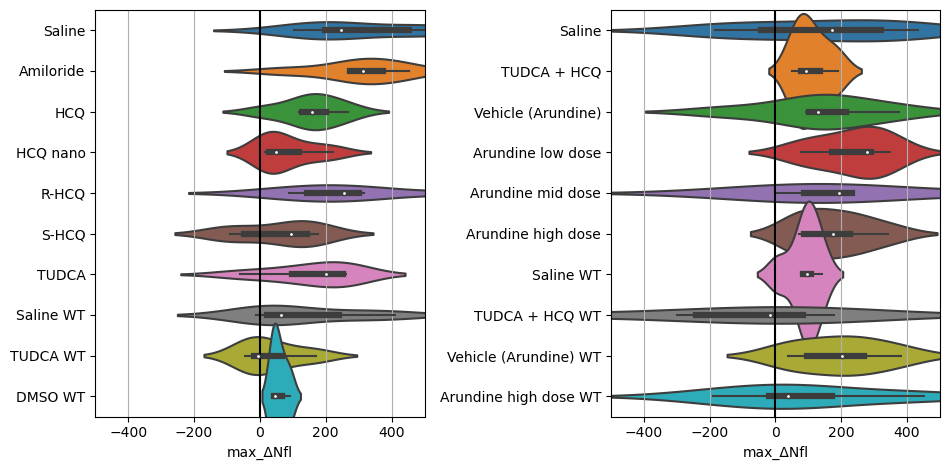

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9.6, 4.8))
for axi, dataw in zip(ax, [dataw_CO28152, dataw_CO28154]):
    axi.grid()
    sns.violinplot(data=dataw, x='max_ΔNfl', y='Treatment', ax=axi, width=3.6)
    axi.axvline(0, color='black')
    axi.set_ylabel('')
    axi.set_xlim(-500, 500)

plt.tight_layout()
attila_utils.savefig(fig, 'data-violinplot')

In [11]:
def subset_data(sel_treatments=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA'], dataw=dataw_CO28152):
    data = dataw.loc[dataw.Treatment.isin(sel_treatments)].copy()
    data['Treatment'] = pd.Categorical(data.Treatment, categories=sel_treatments, ordered=True)
    return(data)

In [12]:
def fit_bayes(sel_treatments, dataw=dataw_CO28152):
    dataw = dataw.dropna(subset='max_ΔNfl')
    model = bmb.Model('max_ΔNfl ~ 1 + Treatment', subset_data(sel_treatments=sel_treatments, dataw=dataw))
    results = model.fit()
    return(results)

sel_treatments_CO28152=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA']
sel_treatments_CO28154a=['Saline', 'Saline WT', 'TUDCA + HCQ', 'TUDCA + HCQ WT']
sel_treatments_CO28154b=['Vehicle (Arundine)', 'Vehicle (Arundine) WT', 'Arundine low dose', 'Arundine mid dose', 'Arundine high dose', 'Arundine high dose WT']
l_sel_treatments = [sel_treatments_CO28152, sel_treatments_CO28154a, sel_treatments_CO28154b]
l_dataw = [dataw_CO28152, dataw_CO28154, dataw_CO28154]
results_CO28152, results_CO28154a, results_CO28154b = [fit_bayes(st, dw) for st, dw in zip(l_sel_treatments, l_dataw)]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [max_ΔNfl_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [max_ΔNfl_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [max_ΔNfl_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [13]:
az.summary(results_CO28152)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,301.748,61.227,193.494,423.912,1.501,1.067,1664.0,1974.0,1.0
Treatment[Saline WT],-163.866,85.816,-331.314,-11.853,1.855,1.325,2142.0,2874.0,1.0
Treatment[Amiloride],-0.453,87.668,-154.647,173.944,1.787,1.264,2407.0,2832.0,1.0
Treatment[HCQ],-148.172,86.672,-315.531,10.405,1.778,1.257,2377.0,2809.0,1.0
Treatment[HCQ nano],-217.922,85.985,-389.559,-66.564,1.845,1.307,2176.0,2736.0,1.0
Treatment[R-HCQ],-16.551,85.857,-179.007,141.591,1.906,1.348,2031.0,2680.0,1.0
Treatment[S-HCQ],-245.534,85.394,-400.975,-81.829,1.772,1.253,2324.0,2946.0,1.0
Treatment[TUDCA],-144.820,84.586,-294.800,22.293,1.735,1.260,2388.0,2675.0,1.0
max_ΔNfl_sigma,148.114,16.941,117.943,180.307,0.317,0.225,2930.0,2914.0,1.0


In [14]:
az.summary(results_CO28154a)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,138.971,102.092,-63.369,320.143,2.015,1.473,2560.0,2531.0,1.0
Treatment[Saline WT],-49.702,145.746,-331.296,216.542,2.591,2.071,3163.0,3075.0,1.0
Treatment[TUDCA + HCQ],-33.515,145.369,-285.941,257.025,2.632,2.249,3045.0,2466.0,1.0
Treatment[TUDCA + HCQ WT],-298.587,144.012,-555.801,-10.503,2.640,1.913,2969.0,2804.0,1.0
max_ΔNfl_sigma,248.893,39.640,179.892,322.490,0.734,0.522,2911.0,2691.0,1.0


In [15]:
az.summary(results_CO28154b)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,137.698,85.207,-19.922,297.467,1.823,1.292,2182.0,2355.0,1.0
Treatment[Vehicle (Arundine) WT],58.808,119.625,-173.523,271.438,2.330,1.653,2654.0,2903.0,1.0
Treatment[Arundine low dose],93.924,123.621,-145.422,324.517,2.372,1.829,2722.0,2709.0,1.0
Treatment[Arundine mid dose],147.819,124.971,-91.041,377.269,2.275,1.646,3022.0,2990.0,1.0
Treatment[Arundine high dose],39.825,118.393,-196.413,251.722,2.493,1.763,2256.0,2850.0,1.0
Treatment[Arundine high dose WT],-47.928,125.850,-278.314,194.662,2.443,1.728,2657.0,2905.0,1.0
max_ΔNfl_sigma,206.328,27.818,158.005,258.553,0.498,0.354,3151.0,3095.0,1.0


['named-figure/violinplot-CO28152.png', 'named-figure/violinplot-CO28152.pdf']

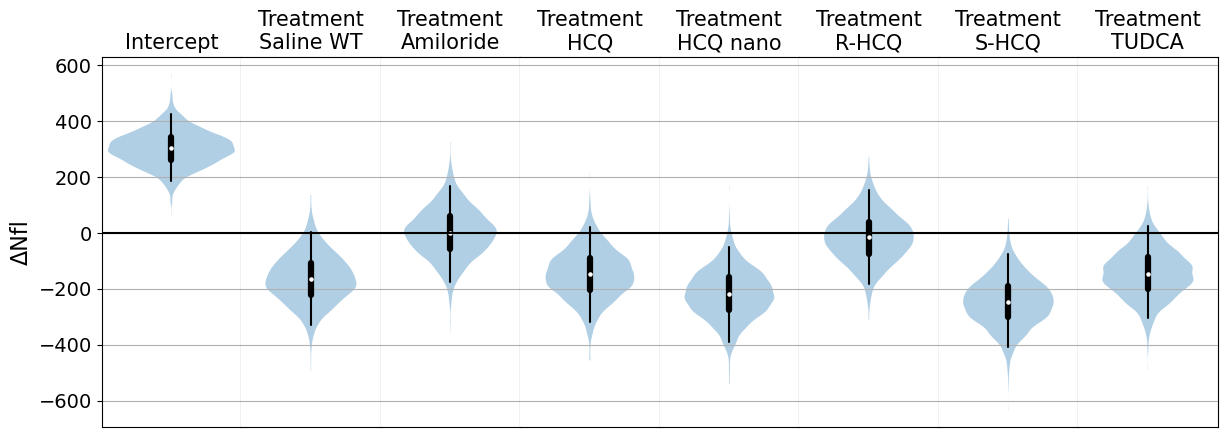

In [16]:
def my_violin(results):
    nvars = results.posterior.variables['Treatment'].shape[2] + 1
    ax = az.plot_violin(results, hdi_prob=0.95, var_names=['Intercept', 'Treatment'], grid=(1, nvars), figsize=(14.4, 4.8))
    for axi in ax:
        axi.axhline(0, color='black')
        axi.grid()
    ax[0].set_ylabel('ΔNfl', fontsize=16)
    fig = ax[0].get_figure()
    return((fig, ax))

fig, ax = my_violin(results_CO28152)
attila_utils.savefig(fig, 'violinplot-CO28152')

['named-figure/violinplot-CO28154a.png',
 'named-figure/violinplot-CO28154a.pdf']

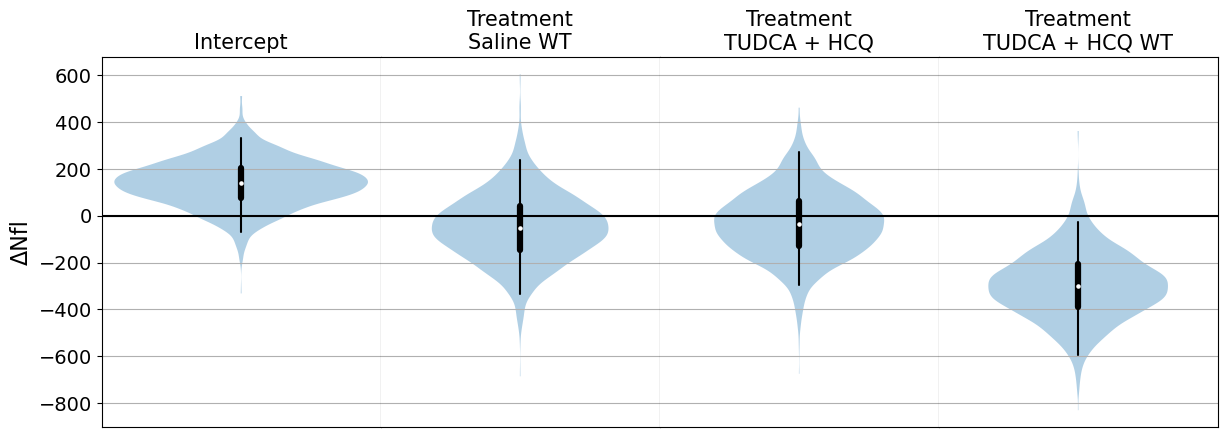

In [17]:
fig, ax = my_violin(results_CO28154a)
attila_utils.savefig(fig, 'violinplot-CO28154a')

['named-figure/violinplot-CO28154b.png',
 'named-figure/violinplot-CO28154b.pdf']

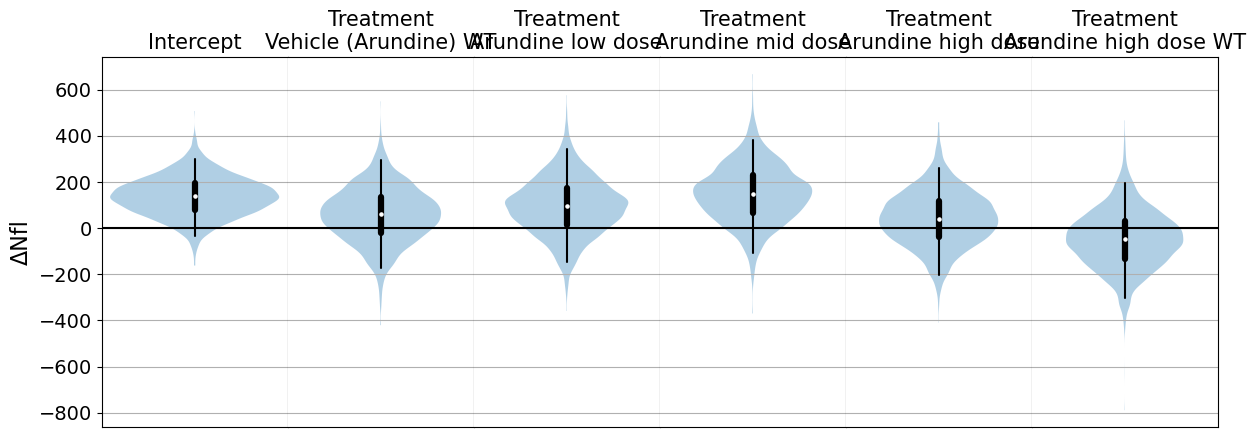

In [18]:
fig, ax = my_violin(results_CO28154b)
attila_utils.savefig(fig, 'violinplot-CO28154b')

['named-figure/forestplot-CO28152.png', 'named-figure/forestplot-CO28152.pdf']

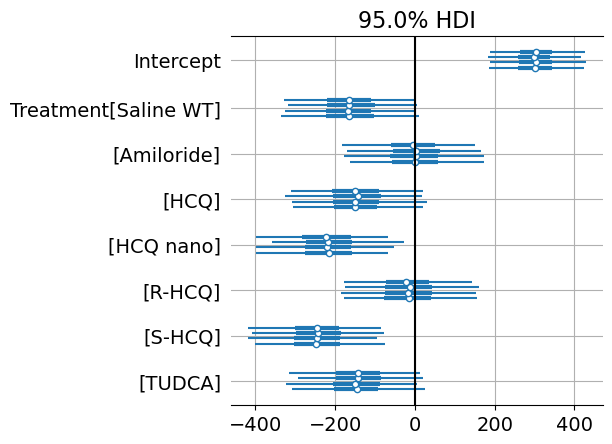

In [19]:
def my_forest(results, var_names='~max_ΔNfl_sigma'):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    az.plot_forest(results, ax=ax, hdi_prob=0.95, var_names=var_names)
    ax.grid()
    ax.axvline(0, color='black')
    return((fig, ax))

fig, ax = my_forest(results_CO28152)
attila_utils.savefig(fig, 'forestplot-CO28152')

['named-figure/forestplot-CO28154a.png',
 'named-figure/forestplot-CO28154a.pdf']

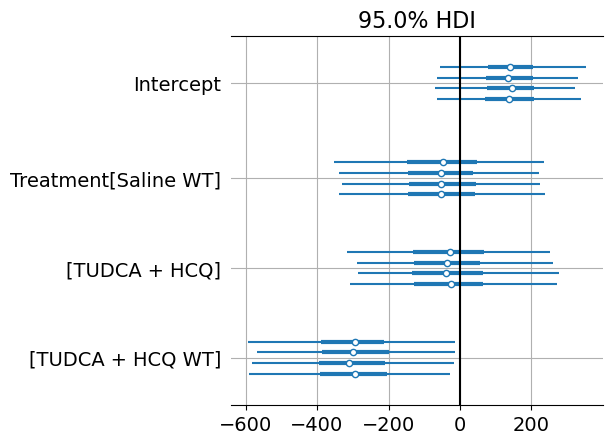

In [20]:
fig, ax = my_forest(results_CO28154a)
attila_utils.savefig(fig, 'forestplot-CO28154a')

['named-figure/forestplot-CO28154b.png',
 'named-figure/forestplot-CO28154b.pdf']

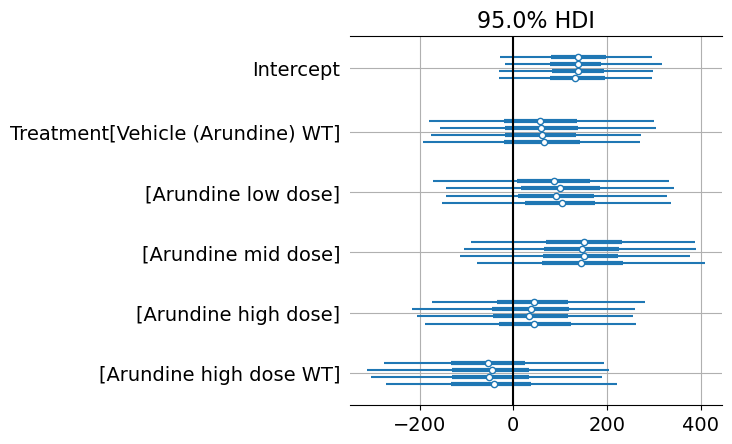

In [21]:
fig, ax = my_forest(results_CO28154b)
attila_utils.savefig(fig, 'forestplot-CO28154b')

In [22]:
results_freq = smf.ols('max_ΔNfl ~ 1 + Treatment', data=subset_data(sel_treatments=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA'])).fit()
results_freq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               max_ΔNfl   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     2.781
Date:                Fri, 31 May 2024   Prob (F-statistic):             0.0187
Time:                        14:25:15   Log-Likelihood:                -302.76
No. Observations:                  48   AIC:                             621.5
Df Residuals:                      40   BIC:                             636.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                303.1667     59.379      5.106      0.000     183.157     423.177
Treatment[T.Saline WT]  -164.8333     83.975     -1.963      0.057    -334.553       4.887
Treatment[T.Amiloride]    -1.6667     83.975     -0.020      0.984    -171.387     168.053
Treatment[T.HCQ]        -148.8333     83.975     -1.772      0.084    -318.553      20.887
Treatment[T.HCQ nano]   -220.6667     83.975     -2.628      0.012    -390.387     -50.947
Treatment[T.R-HCQ]       -18.1667     83.975     -0.216      0.830    -187.887     151.553
Treatment[T.S-HCQ]      -247.1667     83.975     -2.943      0.005    -416.887     -77.447
Treatment[T.TUDCA]      -147.1667     83.975     -1.753      0.087    -316.887      22.553
==============================================================================
Omnibus:                        3.652   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.654
Skew:                           0.544   Prob(JB):                        0.265
Kurtosis:                       3.377   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


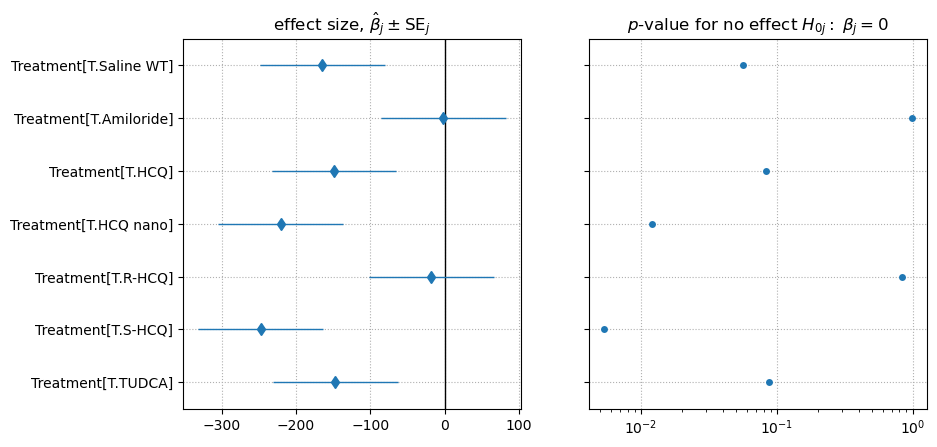

In [23]:
def results2df(results):
    df = pd.concat([results.params.to_frame('mean'),
                    results.bse.to_frame('bse'),
                    results.pvalues.to_frame('pval')], axis=1)
    df['treatment'] = df.index
    return(df)

def result_plotter(df, suptitle='', legend_loc='best'):
    #full_effect_mean, full_effect_se = df.loc['Intercept', ['mean', 'bse']]
    df = df.drop('Intercept', axis=0)
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    #rectL, rectR = [Rectangle(xy=(- full_effect_mean, -0.5), width=full_effect_se, height=df.shape[0] + 1, alpha=0.5, color='lightgreen', angle=a, rotation_point=(- full_effect_mean, df.shape[0]/2)) for a in [180, 0]]
    #ax[0].add_patch(rectL)
    #ax[0].add_patch(rectR)
    ax[0].axvline(0, color='k', linewidth=1)
    ax[0].grid(linestyle='dotted')
    #ax[0].axvline(- full_effect_mean, color='green', linewidth=1, linestyle='solid')
    ax[0].errorbar(y=np.arange(df.shape[0]), x=df['mean'], xerr=df['bse'], linewidth=0, elinewidth=1, marker='d', capsize=0)
    ax[0].set_title(r'effect size, $\hat{\beta}_j \pm \mathrm{SE}_j$')
    #black_line, green_line = [mlines.Line2D([], [], color=color, marker=None, linewidth=1, label=label) for color, label in zip(['black', 'green'], ['no effect', 'full effect'])]
    #ax[0].legend(handles=[black_line, green_line], loc=legend_loc)
    #ax[1].axvline(1, color='k', linewidth=1)
    sns.stripplot(x='pval', y='treatment', ax=ax[1], data=df)
    ax[1].grid(linestyle='dotted')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('')
    ax[1].set_title(r'$p$-value for no effect $H_{0j}: \; \beta_j = 0$')
    fig.suptitle(suptitle)
    return((fig, ax))

fig, ax = result_plotter(results2df(results_freq))

In [24]:
%connect_info

{
  "shell_port": 61926,
  "iopub_port": 61927,
  "stdin_port": 61928,
  "control_port": 61930,
  "hb_port": 61929,
  "ip": "127.0.0.1",
  "key": "8bc8a4fc-812c6dd9bce55db13bb4b772",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-05-20-nfl-modeling/2024-05-20-nfl-modeling.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-dc51da21-a202-47e5-ae6d-7038119c535f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
